In [12]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import time

In [13]:
# --- 1. Data Loading and Preprocessing ---

print("Step 1: Loading and Preprocessing Data...")
start_time = time.time()

# Define the path to your data directory
data_dir = '../data' # Using a relative path from the notebooks folder

Step 1: Loading and Preprocessing Data...


In [14]:
# Get the list of class names from the folder names
class_names = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
print(f"Found {len(class_names)} classes: {class_names}")

Found 10 classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


In [15]:
# --- FIX: Initialize the lists here, in the same cell as the loop ---
images = []
labels = []
# Loop over each class folder
for class_name in class_names:
    class_path = os.path.join(data_dir, class_name)
    image_files = os.listdir(class_path)
    
    # Loop over each image in the class folder
    for image_file in image_files:
        image_path = os.path.join(class_path, image_file)
        
        # Read the image using OpenCV
        image = cv2.imread(image_path)
        
        if image is not None:
            # OpenCV reads images in BGR format, convert it to RGB for consistency
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Resize the image to a standard 64x64
            image = cv2.resize(image, (64, 64))
            
            # Normalize pixel values to be between 0 and 1
            image = image.astype('float32') / 255.0
            
            images.append(image)
            labels.append(class_name)

In [16]:
# Convert lists to NumPy arrays for efficient processing
images = np.array(images)
labels = np.array(labels)

# Use LabelEncoder to convert string labels to integers (e.g., 'Forest' -> 1)
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

Data loading complete. Took 46.33 seconds.
Total images loaded: 27000
Shape of image data: (27000, 64, 64, 3)
Shape of labels: (27000,)


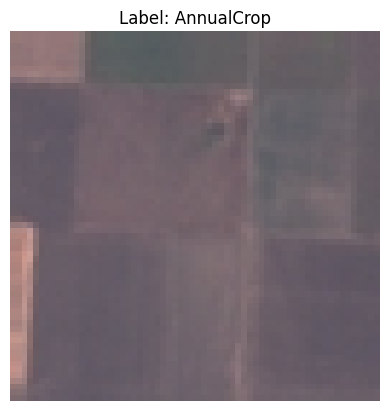

In [17]:
end_time = time.time()
print(f"Data loading complete. Took {end_time - start_time:.2f} seconds.")
print(f"Total images loaded: {len(images)}")
print(f"Shape of image data: {images.shape}")
print(f"Shape of labels: {labels_encoded.shape}")

# Optional: Display a random image to verify
plt.imshow(images[0])
plt.title(f"Label: {labels[0]}")
plt.axis('off')
plt.show()

In [18]:
# --- 2. Feature Extraction and Data Splitting ---

print("\nStep 2: Extracting Features and Splitting Data...")
start_time = time.time()

# We need to reshape the images from (27000, 64, 64, 3) to (27000, 12288) to feed them to some models
# but for histograms, we can iterate through the original images array.
features = []
for image in images:
    # Calculate histogram for each color channel and concatenate them
    hist_r = cv2.calcHist([image], [0], None, [32], [0, 1])
    hist_g = cv2.calcHist([image], [1], None, [32], [0, 1])
    hist_b = cv2.calcHist([image], [2], None, [32], [0, 1])
    
    # Concatenate the histograms into a single feature vector
    hist = np.concatenate((hist_r, hist_g, hist_b)).flatten()
    features.append(hist)

features = np.array(features)

print(f"Feature extraction complete. Shape of feature data: {features.shape}")

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    features, 
    labels_encoded, 
    test_size=0.2, 
    random_state=42,
    stratify=labels_encoded # Ensures the class distribution is the same in train and test sets
)

end_time = time.time()
print(f"Data splitting complete. Took {end_time - start_time:.2f} seconds.")
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")


Step 2: Extracting Features and Splitting Data...
Feature extraction complete. Shape of feature data: (27000, 96)
Data splitting complete. Took 0.92 seconds.
Shape of X_train: (21600, 96)
Shape of X_test: (5400, 96)
Shape of y_train: (21600,)
Shape of y_test: (5400,)


In [19]:
# --- 3. Dimensionality Reduction with PCA ---
print("\nStep 3: Applying PCA for Dimensionality Reduction...")
n_components = 50
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

model_dir = '../models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
joblib.dump(pca, os.path.join(model_dir, 'pca.joblib'))
print(f"PCA object saved to '{os.path.join(model_dir, 'pca.joblib')}'")


# --- 4. NEW STEP: Save Processed Data for the Next Notebook ---
print("\nStep 4: Saving processed data...")
results_dir = '../results'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Save the arrays to files
np.save(os.path.join(results_dir, 'X_train_pca.npy'), X_train_pca)
np.save(os.path.join(results_dir, 'X_test_pca.npy'), X_test_pca)
np.save(os.path.join(results_dir, 'y_train.npy'), y_train)
np.save(os.path.join(results_dir, 'y_test.npy'), y_test)
# Also save the class names for later use
np.save(os.path.join(results_dir, 'class_names.npy'), np.array(class_names))


print("Processed data saved. This notebook is complete.")
print(f"Files saved in '{results_dir}' directory.")



Step 3: Applying PCA for Dimensionality Reduction...
PCA object saved to '../models\pca.joblib'

Step 4: Saving processed data...
Processed data saved. This notebook is complete.
Files saved in '../results' directory.
